##  here we are using oxford iiit pet dataset link for dataset https://www.robots.ox.ac.uk/~vgg/data/pets/. The task will be to classify each pixel of an input image either as pet or background.

Download images that are used in the notebook and save to the images folder in the Colab environment.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
# !unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
# !cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
# !echo "Images are successfully downloaded"

## Install the latest version of Albumentations

In [3]:
#!pip install -q -U albumentations
# !pip uninstall albumentations 
#!echo "$(pip freeze | grep albumentations) is successfully installed"

In [4]:
# !pip install typing_extensions==3.10.0.0

In [5]:
!git clone https://github.com/sunandhini96/TSAI_ERAV1.git

fatal: destination path 'TSAI_ERAV1' already exists and is not an empty directory.


In [6]:
cd TSAI_ERAV1

C:\Users\rajes\Assignment_13\TSAI_ERAV1


In [7]:
cd Session_18/UNet

C:\Users\rajes\Assignment_13\TSAI_ERAV1\Session_18\UNet


In [8]:
from unet_model import *
from utils import *
from main import *

## Install the required libraries

Define functions to download an archived dataset and unpack it

Set the root directory for the downloaded dataset

In [9]:

dataset_directory = os.path.join("C:\\Users\\rajes\\OneDrive\\Desktop\\nandini\\Eva8\\Session 13\\oxford_iiit_petdataset", "datasets\\oxford-iiit-pet")

In [10]:
# filepath = os.path.join(dataset_directory, "images.tar.gz")
# download_url(
#     url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
# )
# extract_archive(filepath)

In [11]:
# filepath = os.path.join(dataset_directory, "annotations.tar.gz")
# download_url(
#     url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
# )
# extract_archive(filepath)

## Split files from the dataset into the train and validation sets





Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 6000 images for training, 1374 images for validation, and 10 images for testing.

In [12]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:6000]
val_images_filenames = correct_images_filenames[6000:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

6000 1374 10


Define a function to preprocess a mask

The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: 1, 2, or 3. 1 means that this pixel of an image belongs to the class pet, 2 - to the class background, 3 - to the class border. Since this example demonstrates a task of binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: 0.0 if a pixel is a background and 1.0 if a pixel is a pet or a border.

Define a function to visualize images and their labels

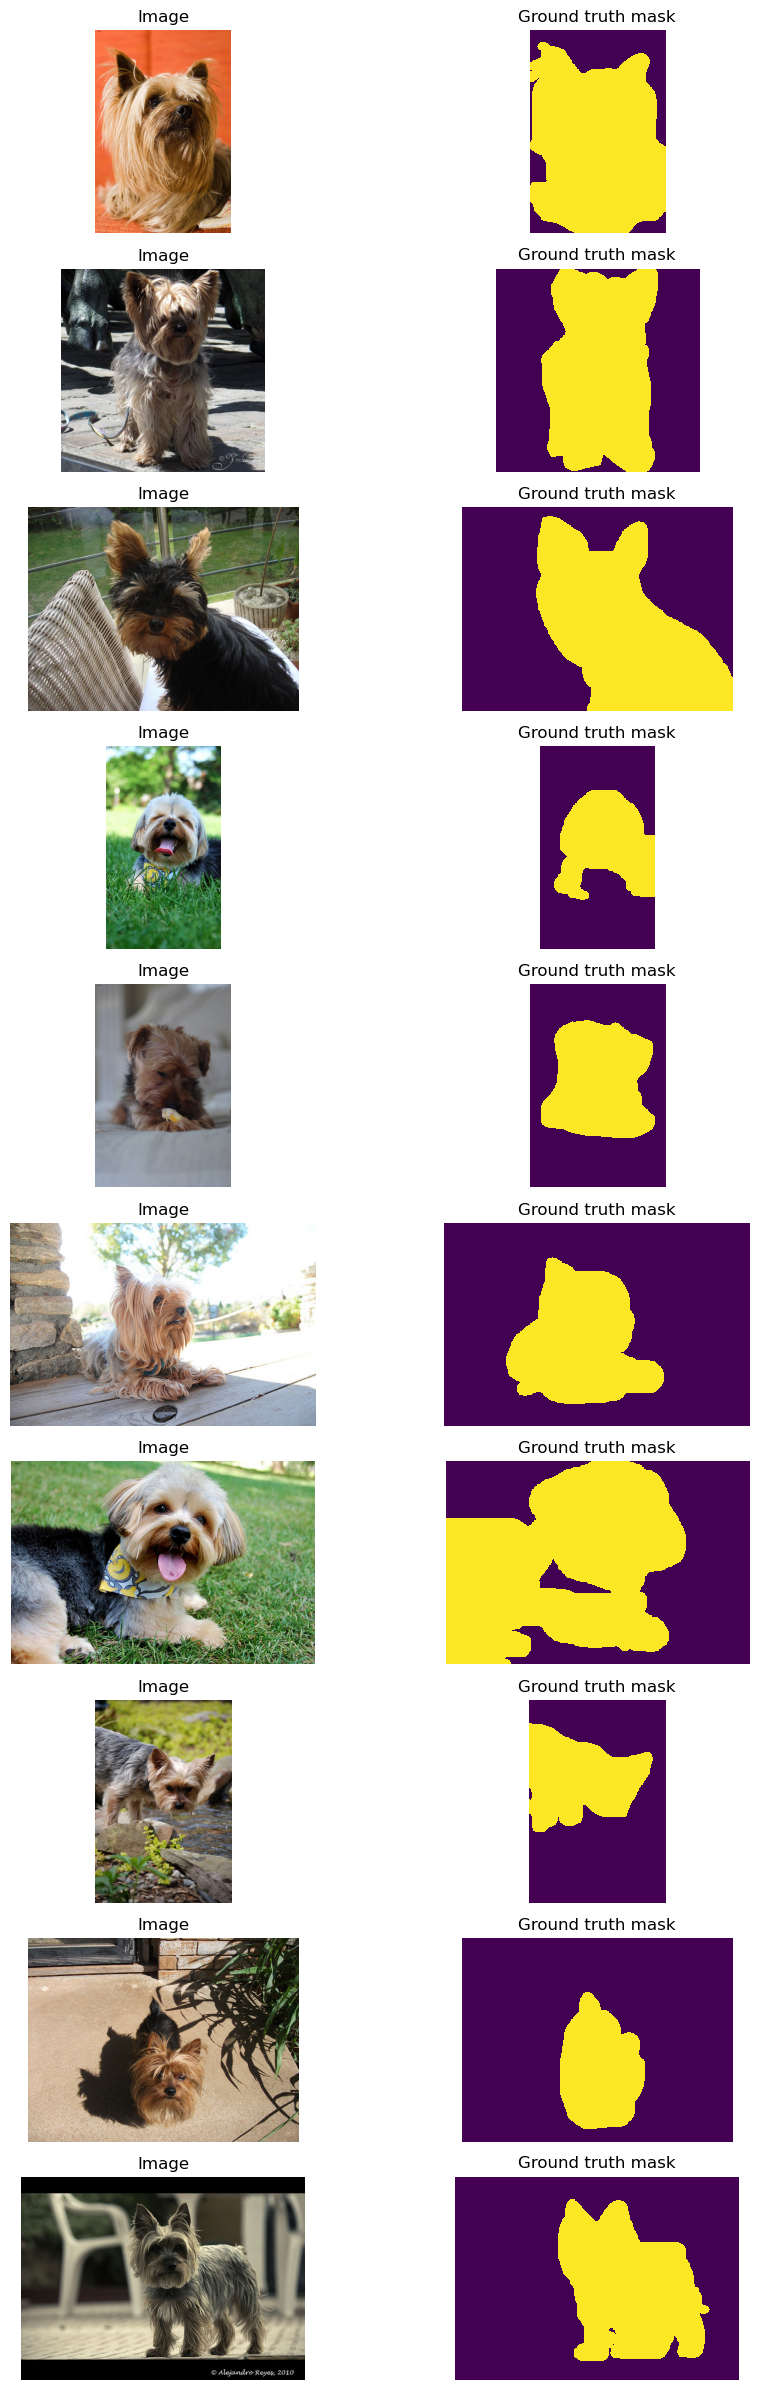

In [13]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

Image sizes for training and prediction

In [14]:
#import albumentations 
example_image_filename = correct_images_filenames[0]
image = cv2.imread(os.path.join(images_directory, example_image_filename))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
import albumentations as A

resized_image = A.Resize(height=256, width=256)(image=image)['image']
padded_image = A.PadIfNeeded(min_height=512, min_width=512)(image=image)['image']
#resized_image = F.resize(image, height=256, width=256)
# resized_image=albumentations.augmentations.transforms.Resize(height=256, width=256)(image=image)['image']
# padded_image =albumentations.augmentations.transforms.PadIfNeeded(min_height=512, min_width=512)(image=image)['image']
#padded_image = F.pad(image, min_height=512, min_width=512)
padded_constant_image = A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT)(image=image)['image']
cropped_image = A.CenterCrop(height=256, width=256)(image=image)['image']

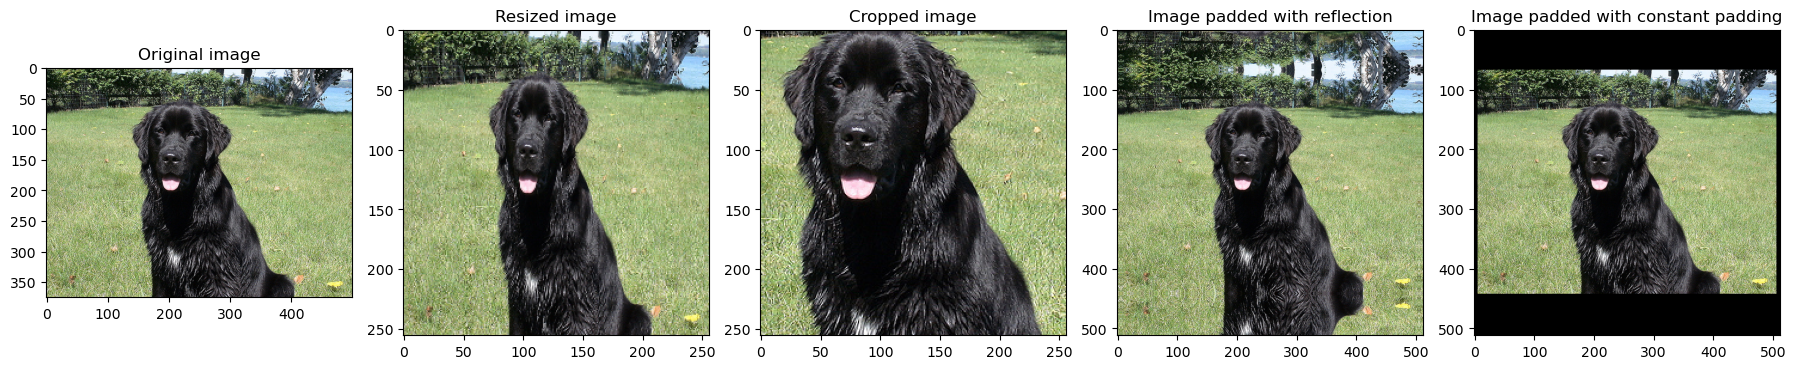

In [15]:
figure, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 10))
ax.ravel()[0].imshow(image)
ax.ravel()[0].set_title("Original image")
ax.ravel()[1].imshow(resized_image)
ax.ravel()[1].set_title("Resized image")
ax.ravel()[2].imshow(cropped_image)
ax.ravel()[2].set_title("Cropped image")
ax.ravel()[3].imshow(padded_image)
ax.ravel()[3].set_title("Image padded with reflection")
ax.ravel()[4].imshow(padded_constant_image)
ax.ravel()[4].set_title("Image padded with constant padding")
plt.tight_layout()
plt.show()

 Resize all images and masks to a fixed size (e.g., 256x256 pixels).

Define a PyTorch dataset class

In [16]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

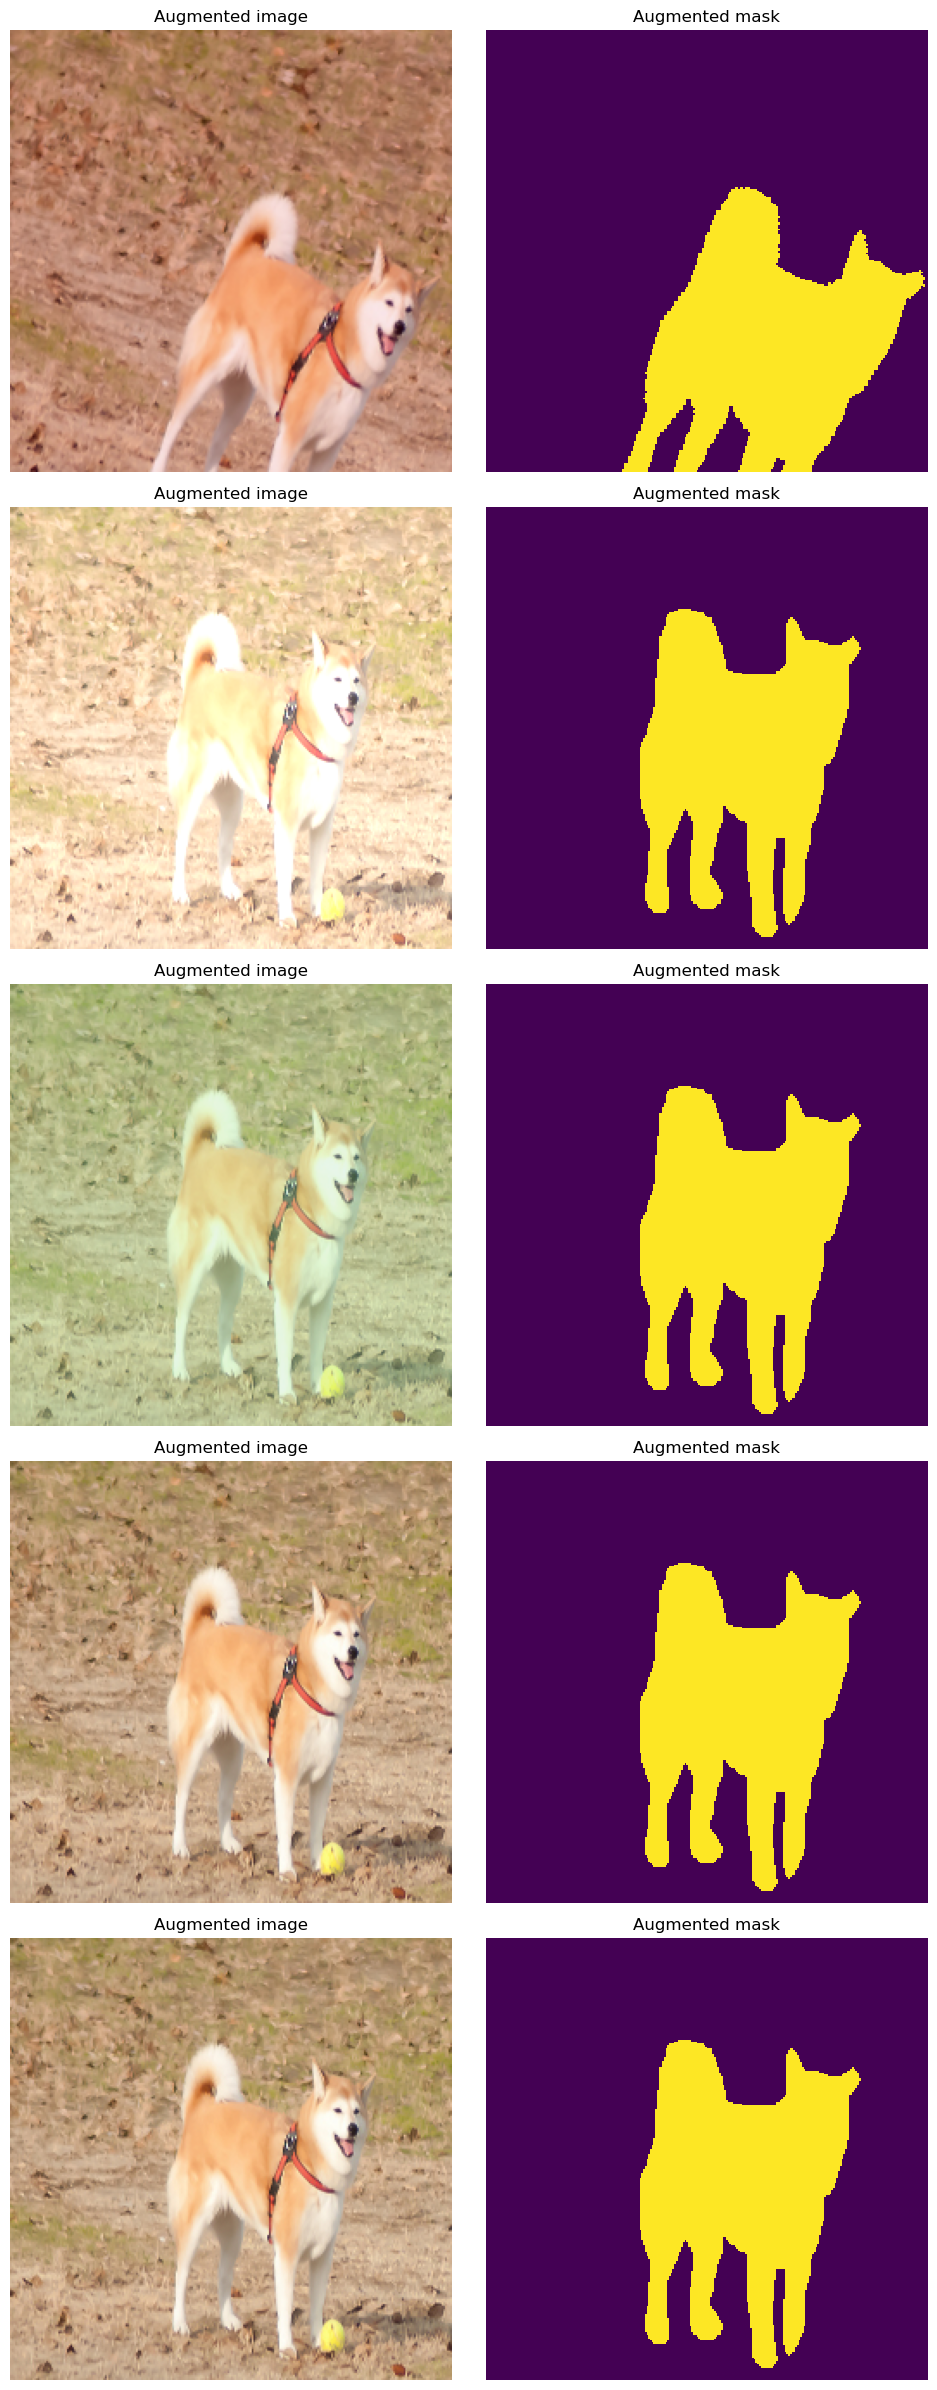

In [17]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

## MP+Tr+BCE


In [18]:
def create_model(params):
    model = UNet(pool="max",up_sample="transpose")
    model = model.to(params["device"])
    return model

In [19]:
params = {
   
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

## Training the model

In [20]:
loss_fn = nn.BCEWithLogitsLoss().to(params["device"])
#loss_fn = DiceLoss().to(params["device"])
model = create_model(params)

model,train_losses,test_losses = train_and_validate(model, train_dataset, val_dataset, params,loss_fn)

Epoch: 10. Validation. Loss: 0.196: 100%|██████████| 86/86 [00:20<00:00,  4.27it/s]


Predict labels for images and visualize those predictions

Now we have a trained model, so let's try to predict masks for some images. Note that the __getitem__ method returns not only an image but also the original height and width of an image. We will use those values to resize a predicted mask from the size of 256x256 pixels to the original image's size.

In [21]:
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [22]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [23]:
params = {
   
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 2,
    "num_workers": 0,
    "epochs": 10,
}

In [24]:
predictions = predict(model, params, test_dataset, batch_size=2)

In [25]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = A.Resize(height=original_height, width=original_width)(image=predicted_256x256_mask)['image']
    # full_sized_mask = F.resize(
    #     predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    # )
    predicted_masks.append(full_sized_mask)

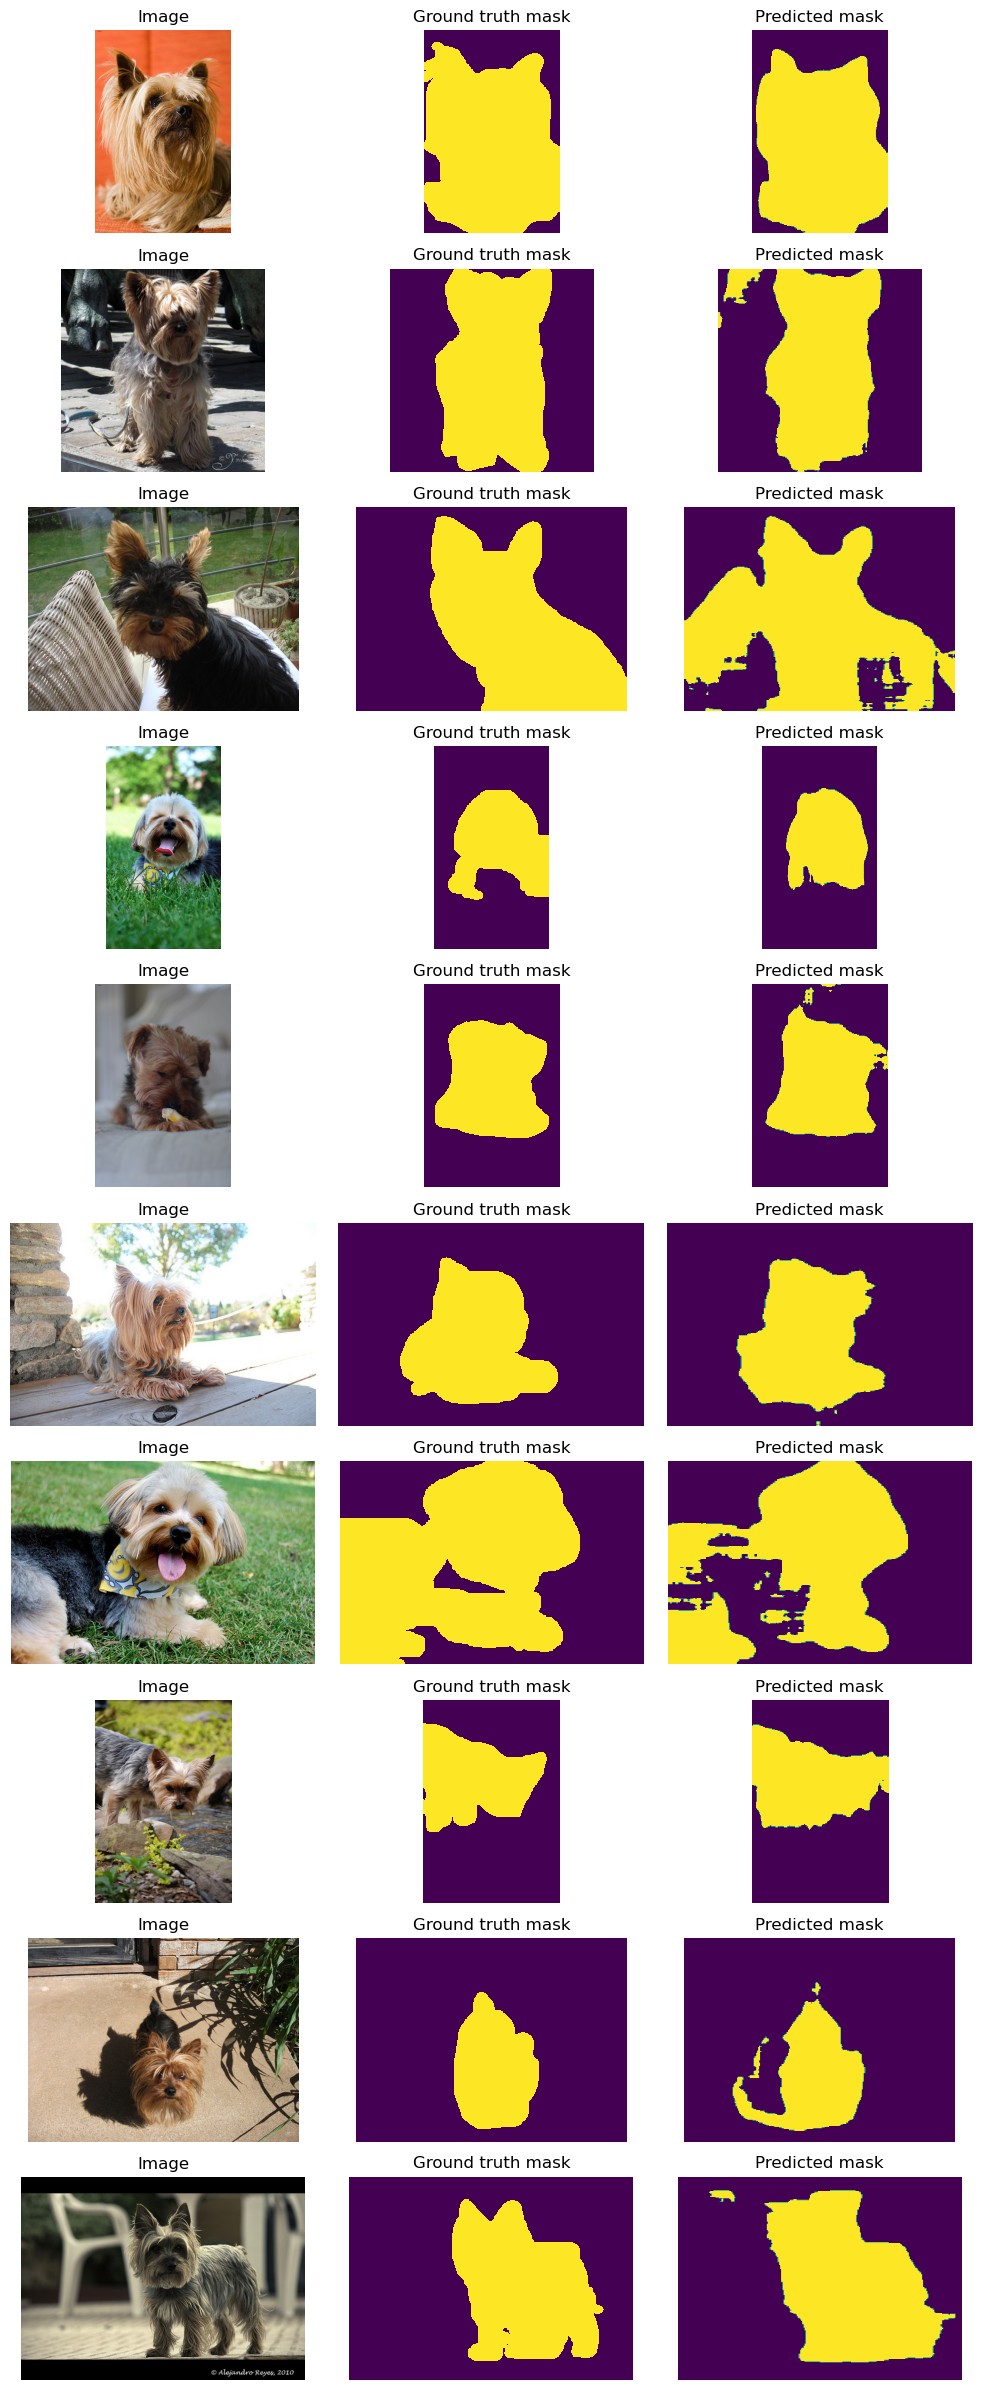

In [26]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

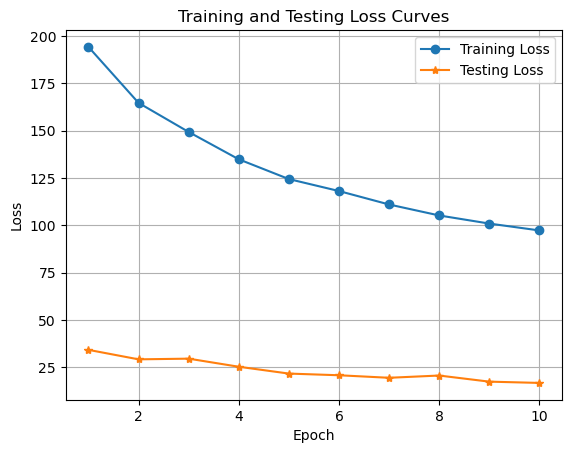

In [27]:
plot_curves(train_losses,test_losses)